Enter your Neo4j connection details:
Neo4j URI (e.g. neo4j+s://<id>.databases.neo4j.io): neo4j+s://275c0b27.databases.neo4j.io
Neo4j username (default 'neo4j'): neo4j
Neo4j password: ··········
✅ MovieLens already present.
ratings.csv MB: 678.26
movies.csv MB: 3.04
📡 Streamed 200,000 rows in 20 batches — mean≈3.566 (sim 0.63s)
✅ Cleaned: 25000095 ratings; 62423 items
Using 2000000 ratings to load into Neo4j.


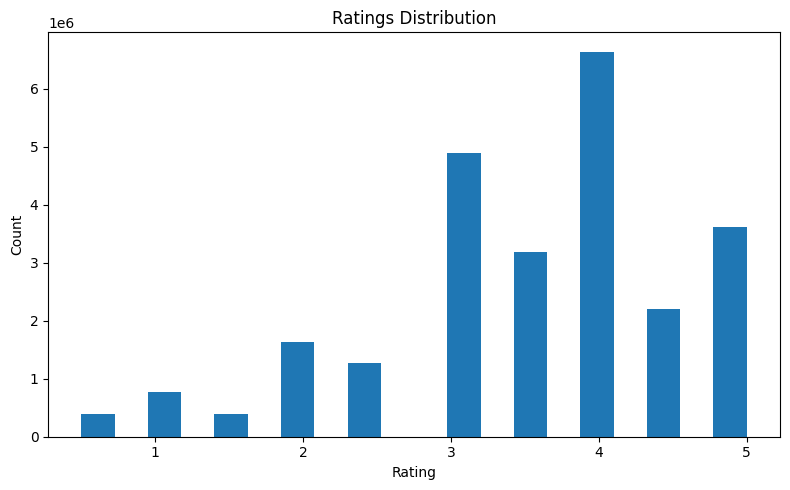

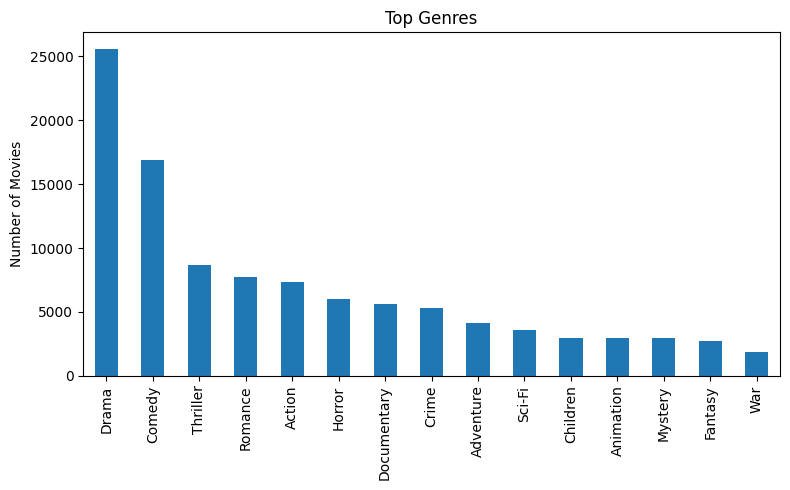

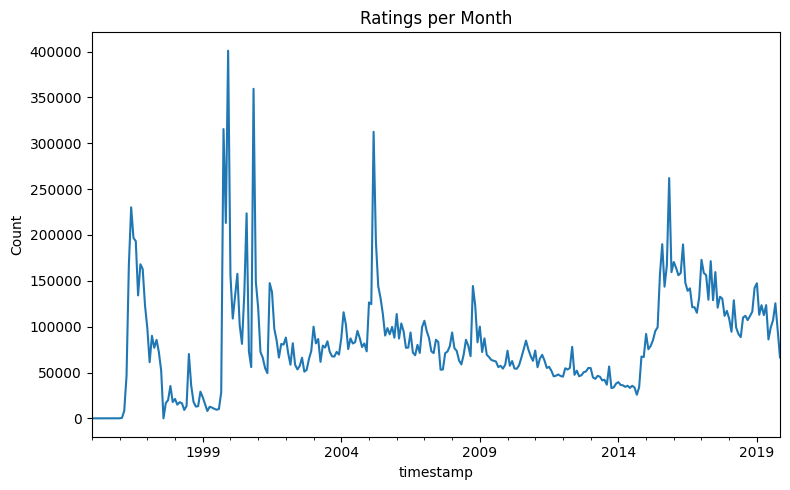

📈 Global rating stats:


,rating
count,2.500010e+07
mean,3.533854e+00
std,1.060744e+00
min,5.000000e-01
25%,3.000000e+00
50%,3.500000e+00
75%,4.000000e+00
max,5.000000e+00


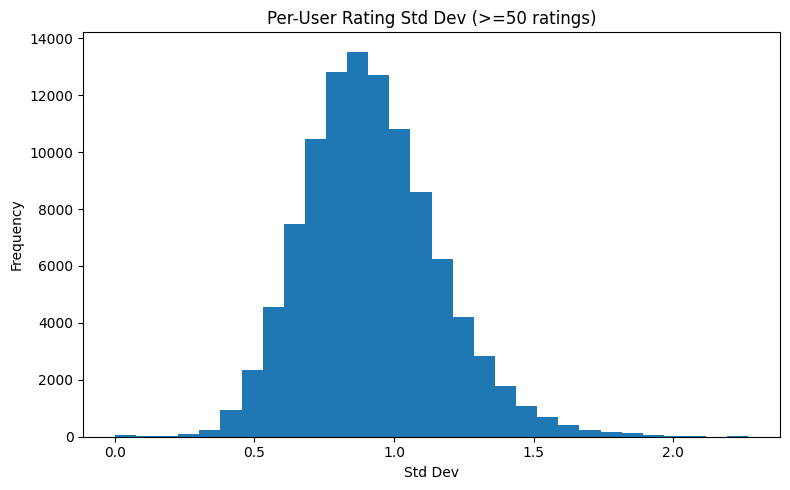

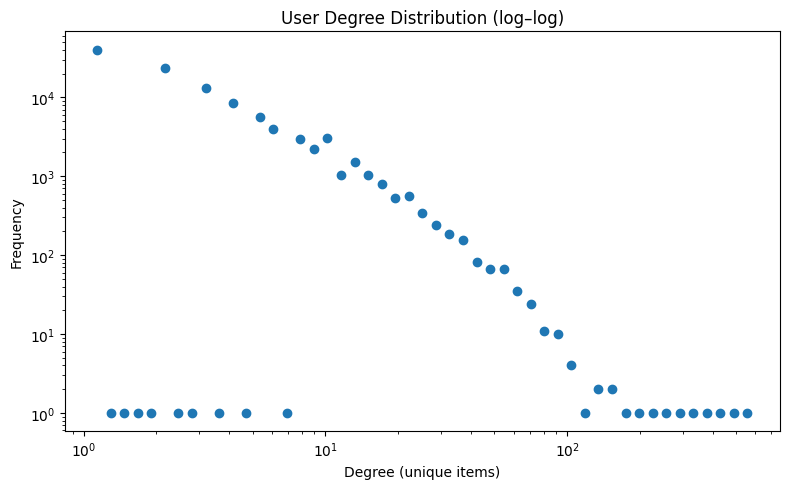

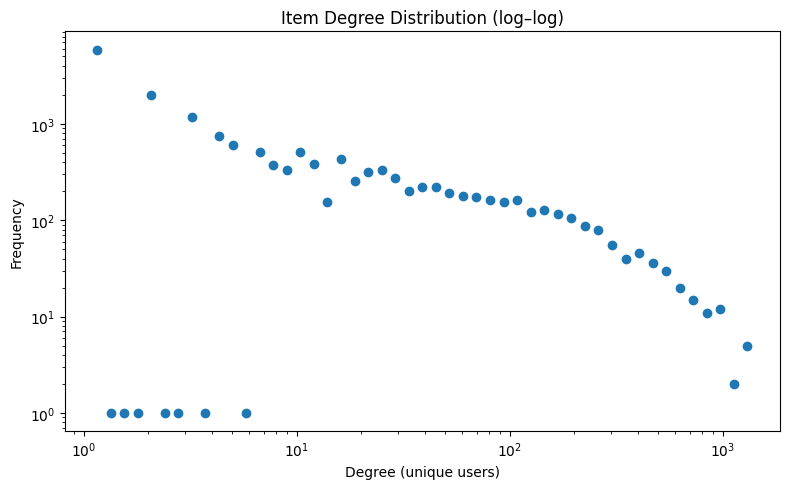

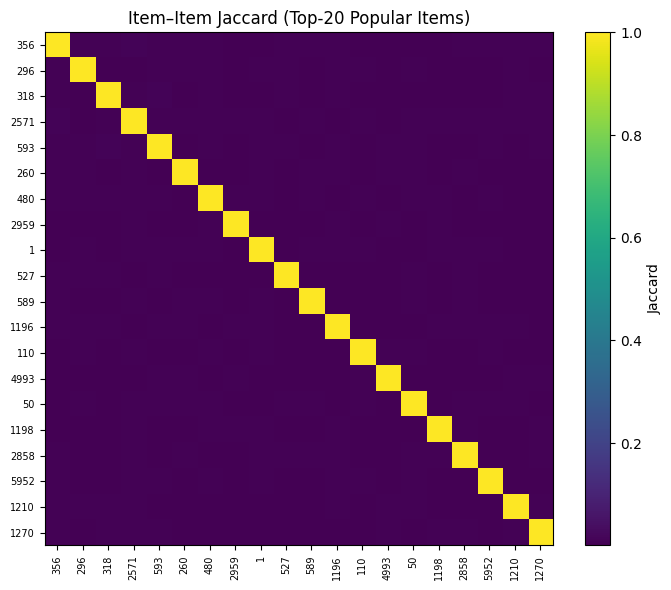


🔗 Connecting to Neo4j…
✅ User constraint created or already exists.
✅ Item constraint created or already exists.

⬆️ Loading items into Neo4j…


Item batches: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]


✅ Items loaded.

⬆️ Loading ratings into Neo4j (this may take several minutes)…


Rating batches: 100%|██████████| 100/100 [04:07<00:00,  2.48s/it]


✅ Ratings loaded into Neo4j.

📊 Running simple queries…
📊 Running complex queries…
   Computing item–item Jaccard (Top15) using Python…

✅ Finished running Neo4j queries.

=== Neo4j Summary ===
Count Users:    156932
Count Items:    62423
Count Ratings:  2000000

--- Top Items by #Ratings (Top10) ---


,itemId,cnt
0,356,6524
1,296,6477
2,318,6451
3,2571,5865
4,593,5791
5,260,5545
6,480,5140
7,527,4828
8,110,4784
9,2959,4701



--- Top Items by Avg Rating (min 50, Top10) ---


,itemId,avg_rating,n
0,159817,4.467890,109
1,318,4.422648,6451
2,171011,4.356383,94
3,166024,4.321839,87
4,858,4.308749,4149
5,7396,4.307692,52
6,50,4.302250,4488
7,65188,4.300000,75
8,32460,4.298701,77
9,170705,4.289256,121



--- 2-Hop Recs for User 1 (Top10) ---


,itemId,score,support
0,123567,5.0,2
1,172577,5.0,2
2,3350,5.0,2
3,5814,5.0,2
4,134326,5.0,2
5,147326,5.0,2
6,2173,5.0,2
7,3737,5.0,2
8,6780,5.0,2
9,120625,5.0,2



--- Item-Item Jaccard (Top15) ---


,itemA,itemB,jacc
1127,4993,5952,0.039131
492,260,1196,0.035703
4593,6874,7438,0.035692
1630,5952,7153,0.035161
1210,1196,1210,0.034949
4047,4886,6377,0.033911
2822,588,595,0.032410
1129,4993,7153,0.031528
494,260,1210,0.031023
972,589,377,0.030843



--- High-Quality Peers >=4★ for User 1 (Top15) ---


,peerId,overlap
0,14876,2
1,130076,2
2,40098,2
3,71544,2
4,89492,2
5,94584,2
6,44724,2
7,91598,2
8,95658,2
9,116714,2



--- Trending Items last 365d (Top15) ---


""



--- Similar Users by Co-Rated Overlap for User 1 (Top15) ---


,otherUser,coRated
0,45373,2
1,71544,2
2,62167,2
3,66713,2
4,93470,2
5,9516,2
6,44724,2
7,91598,2
8,40098,2
9,95658,2


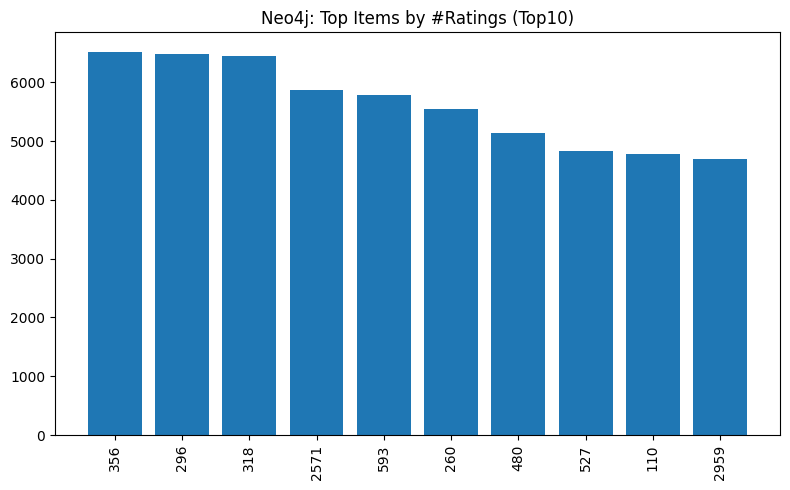

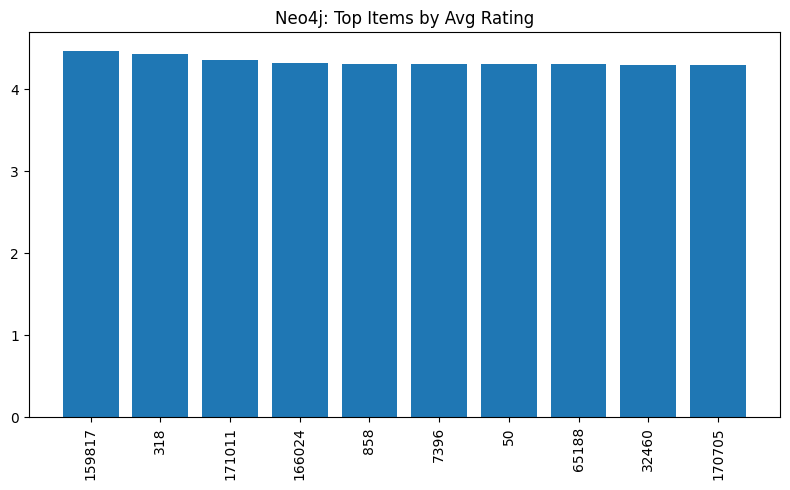

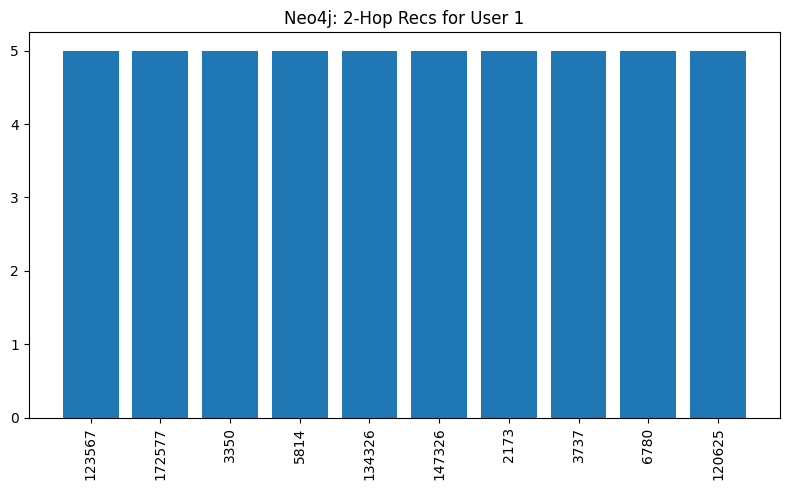

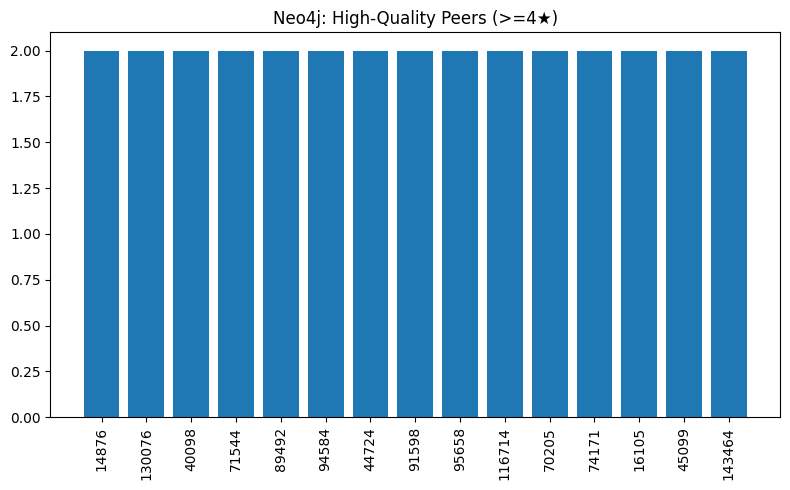

Skipping Neo4j: Trending Items (last 365 days): empty result.


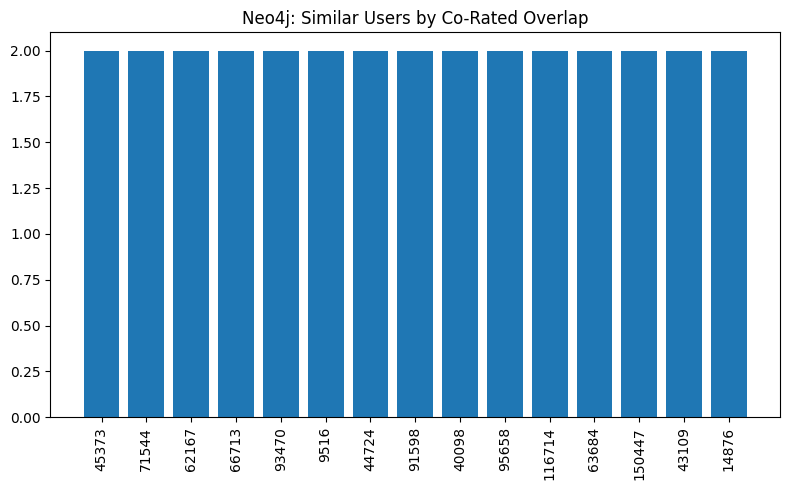


🎉 Done: real Neo4j graph created, big subset loaded,
   5 simple + 5 complex queries executed and visualised.


NameError: name 'matplotlib' is not defined

In [5]:
# ===========================================
# REAL NEO4J PIPELINE WITH CREDENTIAL PROMPT
# MovieLens 25M  →  real Neo4j graph
# - Streaming simulation
# - ETL / preprocessing
# - EDA + visualizations
# - Load big graph into Neo4j
# - 5 simple + 5 complex queries
# - Query result visualizations
# ===========================================

# ------------ 0) INSTALLS (Colab) ------------
import sys, subprocess, importlib

subprocess.run(
    [sys.executable, "-m", "pip", "install", "-q",
     "pandas", "numpy", "matplotlib", "tqdm", "neo4j"]
)
importlib.invalidate_caches()

# ------------ 1) IMPORTS & CONFIG ------------
import os, zipfile, urllib.request, shutil, csv, time
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display

from neo4j import GraphDatabase
import getpass

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = False

# ---------- PROMPT FOR NEO4J CREDENTIALS ----------
print("Enter your Neo4j connection details:")
NEO4J_URI = input("Neo4j URI (e.g. neo4j+s://<id>.databases.neo4j.io): ").strip()
NEO4J_USER = input("Neo4j username (default 'neo4j'): ").strip() or "neo4j"
NEO4J_PASSWORD = getpass.getpass("Neo4j password: ")

if not NEO4J_URI:
    raise ValueError("Neo4j URI cannot be empty.")

# ---------- CONTROLS ----------
STREAM_MAX_ROWS   = 200_000       # rows for streaming demo
STREAM_BATCH      = 10_000
EDGE_SAMPLE       = 2_000_000     # ratings subset to load into Neo4j
MIN_RATINGS_FOR_AVG = 50
TOPK_DEFAULT      = 15

DATA_DIR, CLEAN_DIR = "data", "data/clean"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(CLEAN_DIR, exist_ok=True)

ratings_csv = os.path.join(DATA_DIR, "ratings.csv")
movies_csv  = os.path.join(DATA_DIR, "movies.csv")

# ------------ 2) DOWNLOAD MOVIELENS 25M ------------
if not (os.path.exists(ratings_csv) and os.path.exists(movies_csv)):
    print("⬇️ Downloading MovieLens 25M (≈250MB zip)…")
    zip_path = os.path.join(DATA_DIR, "ml-25m.zip")
    urllib.request.urlretrieve(
        "https://files.grouplens.org/datasets/movielens/ml-25m.zip",
        zip_path
    )
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extract("ml-25m/ratings.csv", DATA_DIR)
        z.extract("ml-25m/movies.csv",  DATA_DIR)
    shutil.move(os.path.join(DATA_DIR, "ml-25m", "ratings.csv"), ratings_csv)
    shutil.move(os.path.join(DATA_DIR, "ml-25m", "movies.csv"),  movies_csv)
    shutil.rmtree(os.path.join(DATA_DIR, "ml-25m"), ignore_errors=True)
    os.remove(zip_path)
else:
    print("✅ MovieLens already present.")

print("ratings.csv MB:", round(os.path.getsize(ratings_csv)/1e6, 2))
print("movies.csv MB:",  round(os.path.getsize(movies_csv)/1e6, 2))

# ------------ 3) STREAMING SIMULATION ------------
def stream_rows(csv_path, max_rows=200_000, batch=10_000):
    buf = []
    with open(csv_path, newline="", encoding="utf-8") as f:
        rd = csv.DictReader(f)
        for i, row in enumerate(rd, 1):
            buf.append(row)
            if len(buf) >= batch:
                yield buf
                buf = []
            if i >= max_rows:
                break
    if buf:
        yield buf

rating_sum = 0.0
rating_n   = 0
batches    = 0
t0 = time.time()
for b in stream_rows(ratings_csv, STREAM_MAX_ROWS, STREAM_BATCH):
    dfb = pd.DataFrame(b)
    dfb["rating"] = dfb["rating"].astype(float)
    rating_sum += dfb["rating"].sum()
    rating_n   += len(dfb)
    batches    += 1
mean_stream = rating_sum / max(rating_n, 1)
sim_secs    = time.time() - t0
print("📡 Streamed {:,} rows in {} batches — mean≈{:.3f} (sim {:.2f}s)".format(
    rating_n, batches, mean_stream, sim_secs
))

# ------------ 4) PREPROCESSING (SAME AS BEFORE) ------------
def preprocess(ratings_path, movies_path, out_dir):
    r = pd.read_csv(ratings_path).rename(columns={"movieId": "itemId"})
    r["timestamp"] = pd.to_datetime(r["timestamp"], unit="s", errors="coerce")

    m = pd.read_csv(movies_path).rename(columns={"movieId": "itemId"})
    m["year"]  = m["title"].str.extract(r"\((\d{4})\)").astype("Int64")
    m["title"] = m["title"].str.replace(r"\(\d{4}\)", "", regex=True).str.strip()
    m.loc[m["genres"] == "(no genres listed)", "genres"] = pd.NA

    os.makedirs(out_dir, exist_ok=True)
    r.to_csv(os.path.join(out_dir, "ratings_clean.csv"), index=False)
    m.to_csv(os.path.join(out_dir, "items_clean.csv"),   index=False)
    return r, m

ratings_df, items_df = preprocess(ratings_csv, movies_csv, CLEAN_DIR)

# Big subset to load into Neo4j
if len(ratings_df) > EDGE_SAMPLE:
    ratings_for_neo4j = ratings_df.sample(EDGE_SAMPLE, random_state=42)
else:
    ratings_for_neo4j = ratings_df

print("✅ Cleaned: {} ratings; {} items".format(len(ratings_df), len(items_df)))
print("Using {} ratings to load into Neo4j.".format(len(ratings_for_neo4j)))

# ------------ 5) EDA & VISUALISATIONS ------------
# 5.1 Ratings histogram
plt.figure()
ratings_df["rating"].plot(kind="hist", bins=20, title="Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5.2 Top genres
genres = (
    items_df["genres"].dropna()
    .str.get_dummies(sep="|")
    .sum()
    .sort_values(ascending=False)
    .head(15)
)
plt.figure()
genres.plot(kind="bar", title="Top Genres")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

# 5.3 Ratings per month
r_month = (
    ratings_df.dropna(subset=["timestamp"])
    .set_index("timestamp")
    .resample("MS")["rating"]   # 'MS' = Month Start
    .count()
)
plt.figure()
r_month.plot(title="Ratings per Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5.4 Global stats
print("📈 Global rating stats:")
display(ratings_df["rating"].describe())

# 5.5 Per-user std dev
per_user = (
    ratings_df.groupby("userId")["rating"]
    .agg(["count", "mean", "std"])
    .reset_index()
)
plt.figure()
per_user[per_user["count"] >= 50]["std"].plot(
    kind="hist", bins=30,
    title="Per-User Rating Std Dev (>=50 ratings)"
)
plt.xlabel("Std Dev")
plt.tight_layout()
plt.show()

# 5.6 Paper-style: degree distributions
ratings_sub = ratings_df.sample(
    min(400_000, len(ratings_df)), random_state=42
)

user_deg = ratings_sub.groupby("userId")["itemId"].nunique()
item_deg = ratings_sub.groupby("itemId")["userId"].nunique()

def loglog_hist(series, title, xlabel):
    series = series[series > 0]
    if series.empty:
        print("No positive data for", title)
        return
    maxv = int(series.max())
    if maxv < 2:
        maxv = 2
    bins = np.logspace(0, np.log10(maxv + 1), 50)
    hist, edges = np.histogram(series, bins=bins)
    hist = np.maximum(1, hist)
    plt.figure()
    plt.loglog(edges[1:], hist, marker="o", ls="none")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

loglog_hist(user_deg, "User Degree Distribution (log–log)", "Degree (unique items)")
loglog_hist(item_deg, "Item Degree Distribution (log–log)", "Degree (unique users)")

# 5.7 Item–item Jaccard heatmap for top-20 items
top_items = item_deg.sort_values(ascending=False).head(20).index.tolist()
users_per_item = {
    i: set(ratings_sub.loc[ratings_sub["itemId"] == i, "userId"].values)
    for i in top_items
}
J = np.zeros((len(top_items), len(top_items)))
for a_i, a in enumerate(top_items):
    Ua = users_per_item[a]
    for b_i, b in enumerate(top_items):
        if a == b:
            J[a_i, b_i] = 1.0
        else:
            Ub = users_per_item[b]
            inter = len(Ua & Ub)
            union = len(Ua | Ub) or 1
            J[a_i, b_i] = inter / union

plt.figure(figsize=(7, 6))
plt.imshow(J, aspect="auto")
plt.colorbar(label="Jaccard")
plt.title("Item–Item Jaccard (Top-20 Popular Items)")
plt.xticks(range(len(top_items)), top_items, rotation=90, fontsize=7)
plt.yticks(range(len(top_items)), top_items, fontsize=7)
plt.tight_layout()
plt.show()

# ------------ 6) CONNECT TO REAL NEO4J ------------
print("\n🔗 Connecting to Neo4j…")
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# ------------ 7) SCHEMA: CONSTRAINTS ------------
with driver.session() as session:
    for desc, cypher in [
        ("User constraint", "CREATE CONSTRAINT IF NOT EXISTS FOR (u:User) REQUIRE u.userId IS UNIQUE"),
        ("Item constraint", "CREATE CONSTRAINT IF NOT EXISTS FOR (i:Item) REQUIRE i.itemId IS UNIQUE"),
    ]:
        try:
            session.run(cypher).consume()
            print(f"✅ {desc} created or already exists.")
        except Exception as e:
            print(f"⚠️ Skipping '{desc}' due to: {e}")

# ------------ 8) LOAD ITEMS INTO NEO4J ------------
print("\n⬆️ Loading items into Neo4j…")

items_to_load = items_df.copy()
items_to_load["year"] = items_to_load["year"].astype("Int64")

def items_chunker(df, size=5000):
    for start in range(0, len(df), size):
        yield df.iloc[start:start+size]

with driver.session() as session:
    for chunk in tqdm(list(items_chunker(items_to_load, 5000)), desc="Item batches"):
        rows = []
        for _, row in chunk.iterrows():
            rows.append({
                "itemId": int(row["itemId"]),
                "title": row["title"],
                "year": None if pd.isna(row["year"]) else int(row["year"]),
                "genres": None if pd.isna(row["genres"]) else row["genres"],
            })
        session.run("""
        UNWIND $rows AS row
        MERGE (i:Item {itemId: row.itemId})
        SET i.title  = row.title,
            i.year   = row.year,
            i.genres = row.genres
        """, rows=rows).consume()

print("✅ Items loaded.")

# ------------ 9) LOAD RATINGS INTO NEO4J ------------
print("\n⬆️ Loading ratings into Neo4j (this may take several minutes)…")

ratings_to_load = ratings_for_neo4j.copy()
ratings_to_load = ratings_to_load.sort_values("timestamp")

def ratings_chunker(df, size=20_000):
    for start in range(0, len(df), size):
        yield df.iloc[start:start+size]

with driver.session() as session:
    for chunk in tqdm(list(ratings_chunker(ratings_to_load, 20_000)), desc="Rating batches"):
        rows = []
        for _, row in chunk.iterrows():
            ts = row["timestamp"]
            ts_str = None
            if pd.notna(ts):
                ts_str = ts.isoformat()
            rows.append({
                "userId": int(row["userId"]),
                "itemId": int(row["itemId"]),
                "rating": float(row["rating"]),
                "ts": ts_str
            })
        session.run("""
        UNWIND $rows AS row
        MERGE (u:User {userId: row.userId})
        MERGE (i:Item {itemId: row.itemId})
        MERGE (u)-[r:RATED]->(i)
        SET r.rating = row.rating,
            r.ts     = row.ts
        """, rows=rows).consume()

print("✅ Ratings loaded into Neo4j.")

# ------------ 10) QUERY HELPERS ------------
def run_df(session, cypher, params=None):
    result = session.run(cypher, params or {})
    records = list(result)
    if not records:
        return pd.DataFrame()
    cols = records[0].keys()
    return pd.DataFrame([r.data() for r in records], columns=cols)

neo_results = {}

with driver.session() as session:
    print("\n📊 Running simple queries…")
    # 1) Count Users
    df = run_df(session, "MATCH (u:User) RETURN count(u) AS users")
    neo_results["Count Users"] = int(df["users"].iloc[0])

    # 2) Count Items
    df = run_df(session, "MATCH (i:Item) RETURN count(i) AS items")
    neo_results["Count Items"] = int(df["items"].iloc[0])

    # 3) Count Ratings
    df = run_df(session, "MATCH ()-[r:RATED]->() RETURN count(r) AS ratings")
    neo_results["Count Ratings"] = int(df["ratings"].iloc[0])

    # 4) Top Items by #Ratings (Top10)
    neo_results["Top Items by #Ratings (Top10)"] = run_df(session, """
    MATCH (i:Item)<-[r:RATED]-()
    RETURN i.itemId AS itemId, count(r) AS cnt
    ORDER BY cnt DESC
    LIMIT 10
    """)

    # 5) Top Items by Avg Rating (min support)
    neo_results[f"Top Items by Avg Rating (min {MIN_RATINGS_FOR_AVG}, Top10)"] = run_df(session, """
    MATCH (i:Item)<-[r:RATED]-()
    WITH i, avg(r.rating) AS avg_rating, count(r) AS n
    WHERE n >= $minc
    RETURN i.itemId AS itemId, avg_rating, n
    ORDER BY avg_rating DESC
    LIMIT 10
    """, {"minc": MIN_RATINGS_FOR_AVG})

    print("📊 Running complex queries…")

    # Complex 1: 2-Hop Recs for User 1
    neo_results["2-Hop Recs for User 1 (Top10)"] = run_df(session, """
    MATCH (u:User {userId: 1})-[:RATED]->(i1:Item)<-[:RATED]-(peer:User)-[r2:RATED]->(i2:Item)
    WHERE NOT (u)-[:RATED]->(i2) AND i2 <> i1
    WITH i2, avg(r2.rating) AS score, count(*) AS support
    RETURN i2.itemId AS itemId, score, support
    ORDER BY score DESC, support DESC
    LIMIT 10
    """)

    # Complex 2: Item-Item Jaccard (Top15) – get top 100 popular items, then compute Jaccard in Python
    print("   Computing item–item Jaccard (Top15) using Python…")
    top_pop_df = run_df(session, """
    MATCH (i:Item)<-[r:RATED]-()
    RETURN i.itemId AS itemId, count(r) AS cnt
    ORDER BY cnt DESC
    LIMIT 100
    """)
    top_ids = top_pop_df["itemId"].tolist()

    users_for_item = {}
    for iid in top_ids:
        df_u = run_df(session, """
        MATCH (i:Item {itemId: $itemId})<-[:RATED]-(u:User)
        RETURN u.userId AS userId
        """, {"itemId": iid})
        users_for_item[iid] = set(df_u["userId"].tolist())

    pairs = []
    for i_idx, ia in enumerate(top_ids):
        Ua = users_for_item[ia]
        for ib in top_ids[i_idx+1:]:
            Ub = users_for_item[ib]
            inter = len(Ua & Ub)
            union = len(Ua | Ub) or 1
            jacc = inter / union
            pairs.append({"itemA": ia, "itemB": ib, "jacc": jacc})
    jacc_df = pd.DataFrame(pairs).sort_values("jacc", ascending=False).head(15)
    neo_results["Item-Item Jaccard (Top15)"] = jacc_df

    # Complex 3: High-Quality Peers >=4★ for User 1
    neo_results["High-Quality Peers >=4★ for User 1 (Top15)"] = run_df(session, """
    MATCH (u:User {userId: 1})-[:RATED]->(i:Item)<-[r:RATED]-(peer:User)
    WHERE peer <> u AND r.rating >= 4.0
    RETURN peer.userId AS peerId, count(*) AS overlap
    ORDER BY overlap DESC
    LIMIT 15
    """)

    # Complex 4: Trending Items last 365d (Top15)
    neo_results["Trending Items last 365d (Top15)"] = run_df(session, """
    MATCH ()-[r:RATED]->(i:Item)
    WHERE r.ts IS NOT NULL AND datetime(r.ts) >= datetime() - duration('P365D')
    RETURN i.itemId AS itemId, count(r) AS cnt
    ORDER BY cnt DESC
    LIMIT 15
    """)

    # Complex 5: Similar Users by Co-Rated Overlap for User 1
    neo_results["Similar Users by Co-Rated Overlap for User 1 (Top15)"] = run_df(session, """
    MATCH (u:User {userId: 1})-[:RATED]->(i:Item)<-[:RATED]-(other:User)
    WHERE other <> u
    RETURN other.userId AS otherUser, count(i) AS coRated
    ORDER BY coRated DESC
    LIMIT 15
    """)

print("\n✅ Finished running Neo4j queries.")

# ------------ 11) VISUALISE NEO4J QUERY RESULTS ------------
def maybe_bar(df_, xcol, ycol, title):
    if not isinstance(df_, pd.DataFrame) or df_.empty:
        print(f"Skipping {title}: empty result.")
        return
    if xcol not in df_.columns or ycol not in df_.columns:
        print(f"Skipping {title}: missing {xcol} or {ycol}.")
        return
    plt.figure()
    plt.bar(range(len(df_)), df_[ycol])
    plt.xticks(range(len(df_)), df_[xcol].astype(str), rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("\n=== Neo4j Summary ===")
print("Count Users:   ", neo_results["Count Users"])
print("Count Items:   ", neo_results["Count Items"])
print("Count Ratings: ", neo_results["Count Ratings"])

for key, val in neo_results.items():
    if isinstance(val, pd.DataFrame):
        print(f"\n--- {key} ---")
        display(val.head(15))

# Bar charts for key results
maybe_bar(
    neo_results["Top Items by #Ratings (Top10)"],
    "itemId", "cnt",
    "Neo4j: Top Items by #Ratings (Top10)"
)

avg_key = f"Top Items by Avg Rating (min {MIN_RATINGS_FOR_AVG}, Top10)"
maybe_bar(
    neo_results[avg_key],
    "itemId", "avg_rating",
    "Neo4j: Top Items by Avg Rating"
)

maybe_bar(
    neo_results["2-Hop Recs for User 1 (Top10)"],
    "itemId", "score",
    "Neo4j: 2-Hop Recs for User 1"
)

maybe_bar(
    neo_results["High-Quality Peers >=4★ for User 1 (Top15)"],
    "peerId", "overlap",
    "Neo4j: High-Quality Peers (>=4★)"
)

maybe_bar(
    neo_results["Trending Items last 365d (Top15)"],
    "itemId", "cnt",
    "Neo4j: Trending Items (last 365 days)"
)

maybe_bar(
    neo_results["Similar Users by Co-Rated Overlap for User 1 (Top15)"],
    "otherUser", "coRated",
    "Neo4j: Similar Users by Co-Rated Overlap"
)

print("\n🎉 Done: real Neo4j graph created, big subset loaded,")
print("   5 simple + 5 complex queries executed and visualised.")
# ===========================================
# REAL NEO4J PIPELINE WITH CREDENTIAL PROMPT
# MovieLens 25M  →  real Neo4j graph
# - Streaming simulation
# - ETL / preprocessing
# - EDA + visualizations
# - Load big graph into Neo4j
# - 5 simple + 5 complex queries
# - Query result visualizations
# ===========================================

# ------------ 0) INSTALLS (Colab) ------------
import sys, subprocess, importlib

subprocess.run(
    [sys.executable, "-m", "pip", "install", "-q",
     "pandas", "numpy", "matplotlib", "tqdm", "neo4j"]
)
importlib.invalidate_caches()

# ------------ 1) IMPORTS & CONFIG ------------
import os, zipfile, urllib.request, shutil, csv, time
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
matplotlib.use('Agg') # Use Agg backend for Matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display

from neo4j import GraphDatabase
import getpass

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = False

# ---------- PROMPT FOR NEO4J CREDENTIALS ----------
print("Enter your Neo4j connection details:")
NEO4J_URI = input("Neo4j URI (e.g. neo4j+s://<id>.databases.neo4j.io): ").strip()
NEO4J_USER = input("Neo4j username (default 'neo4j'): ").strip() or "neo4j"
NEO4J_PASSWORD = getpass.getpass("Neo4j password: ")

if not NEO4J_URI:
    raise ValueError("Neo4j URI cannot be empty.")

# ---------- CONTROLS ----------
STREAM_MAX_ROWS   = 200_000       # rows for streaming demo
STREAM_BATCH      = 10_000
EDGE_SAMPLE       = 2_000_000     # ratings subset to load into Neo4j
MIN_RATINGS_FOR_AVG = 50
TOPK_DEFAULT      = 15

DATA_DIR, CLEAN_DIR = "data", "data/clean"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(CLEAN_DIR, exist_ok=True)

ratings_csv = os.path.join(DATA_DIR, "ratings.csv")
movies_csv  = os.path.join(DATA_DIR, "movies.csv")

# ------------ 2) DOWNLOAD MOVIELENS 25M ------------
if not (os.path.exists(ratings_csv) and os.path.exists(movies_csv)):
    print("⬇️ Downloading MovieLens 25M (≈250MB zip)…")
    zip_path = os.path.join(DATA_DIR, "ml-25m.zip")
    urllib.request.urlretrieve(
        "https://files.grouplens.org/datasets/movielens/ml-25m.zip",
        zip_path
    )
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extract("ml-25m/ratings.csv", DATA_DIR)
        z.extract("ml-25m/movies.csv",  DATA_DIR)
    shutil.move(os.path.join(DATA_DIR, "ml-25m", "ratings.csv"), ratings_csv)
    shutil.move(os.path.join(DATA_DIR, "ml-25m", "movies.csv"),  movies_csv)
    shutil.rmtree(os.path.join(DATA_DIR, "ml-25m"), ignore_errors=True)
    os.remove(zip_path)
else:
    print("✅ MovieLens already present.")

print("ratings.csv MB:", round(os.path.getsize(ratings_csv)/1e6, 2))
print("movies.csv MB:",  round(os.path.getsize(movies_csv)/1e6, 2))

# ------------ 3) STREAMING SIMULATION ------------
def stream_rows(csv_path, max_rows=200_000, batch=10_000):
    buf = []
    with open(csv_path, newline="", encoding="utf-8") as f:
        rd = csv.DictReader(f)
        for i, row in enumerate(rd, 1):
            buf.append(row)
            if len(buf) >= batch:
                yield buf
                buf = []
            if i >= max_rows:
                break
    if buf:
        yield buf

rating_sum = 0.0
rating_n   = 0
batches    = 0
t0 = time.time()
for b in stream_rows(ratings_csv, STREAM_MAX_ROWS, STREAM_BATCH):
    dfb = pd.DataFrame(b)
    dfb["rating"] = dfb["rating"].astype(float)
    rating_sum += dfb["rating"].sum()
    rating_n   += len(dfb)
    batches    += 1
mean_stream = rating_sum / max(rating_n, 1)
sim_secs    = time.time() - t0
print("📡 Streamed {:,} rows in {} batches — mean≈{:.3f} (sim {:.2f}s)".format(
    rating_n, batches, mean_stream, sim_secs
))

# ------------ 4) PREPROCESSING (SAME AS BEFORE) ------------
def preprocess(ratings_path, movies_path, out_dir):
    r = pd.read_csv(ratings_path).rename(columns={"movieId": "itemId"})
    r["timestamp"] = pd.to_datetime(r["timestamp"], unit="s", errors="coerce")

    m = pd.read_csv(movies_path).rename(columns={"movieId": "itemId"})
    m["year"]  = m["title"].str.extract(r"\((\d{4})\)").astype("Int64")
    m["title"] = m["title"].str.replace(r"\(\d{4}\)", "", regex=True).str.strip()
    m.loc[m["genres"] == "(no genres listed)", "genres"] = pd.NA

    os.makedirs(out_dir, exist_ok=True)
    r.to_csv(os.path.join(out_dir, "ratings_clean.csv"), index=False)
    m.to_csv(os.path.join(out_dir, "items_clean.csv"),   index=False)
    return r, m

ratings_df, items_df = preprocess(ratings_csv, movies_csv, CLEAN_DIR)

# Big subset to load into Neo4j
if len(ratings_df) > EDGE_SAMPLE:
    ratings_for_neo4j = ratings_df.sample(EDGE_SAMPLE, random_state=42)
else:
    ratings_for_neo4j = ratings_df

print("✅ Cleaned: {} ratings; {} items".format(len(ratings_df), len(items_df)))
print("Using {} ratings to load into Neo4j.".format(len(ratings_for_neo4j)))

# ------------ 5) EDA & VISUALISATIONS ------------
# 5.1 Ratings histogram
plt.figure()
ratings_df["rating"].plot(kind="hist", bins=20, title="Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5.2 Top genres
genres = (
    items_df["genres"].dropna()
    .str.get_dummies(sep="|")
    .sum()
    .sort_values(ascending=False)
    .head(15)
)
plt.figure()
genres.plot(kind="bar", title="Top Genres")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

# 5.3 Ratings per month
r_month = (
    ratings_df.dropna(subset=["timestamp"])
    .set_index("timestamp")
    .resample("MS")["rating"]   # 'MS' = Month Start
    .count()
)
plt.figure()
r_month.plot(title="Ratings per Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 5.4 Global stats
print("📈 Global rating stats:")
display(ratings_df["rating"].describe())

# 5.5 Per-user std dev
per_user = (
    ratings_df.groupby("userId")["rating"]
    .agg(["count", "mean", "std"])
    .reset_index()
)
plt.figure()
per_user[per_user["count"] >= 50]["std"].plot(
    kind="hist", bins=30,
    title="Per-User Rating Std Dev (>=50 ratings)"
)
plt.xlabel("Std Dev")
plt.tight_layout()
plt.show()

# 5.6 Paper-style: degree distributions
ratings_sub = ratings_df.sample(
    min(400_000, len(ratings_df)), random_state=42
)

user_deg = ratings_sub.groupby("userId")["itemId"].nunique()
item_deg = ratings_sub.groupby("itemId")["userId"].nunique()

def loglog_hist(series, title, xlabel):
    series = series[series > 0]
    if series.empty:
        print("No positive data for", title)
        return
    maxv = int(series.max())
    if maxv < 2:
        maxv = 2
    bins = np.logspace(0, np.log10(maxv + 1), 50)
    hist, edges = np.histogram(series, bins=bins)
    hist = np.maximum(1, hist)
    plt.figure()
    plt.loglog(edges[1:], hist, marker="o", ls="none")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

loglog_hist(user_deg, "User Degree Distribution (log–log)", "Degree (unique items)")
loglog_hist(item_deg, "Item Degree Distribution (log–log)", "Degree (unique users)")

# 5.7 Item–item Jaccard heatmap for top-20 items
top_items = item_deg.sort_values(ascending=False).head(20).index.tolist()
users_per_item = {
    i: set(ratings_sub.loc[ratings_sub["itemId"] == i, "userId"].values)
    for i in top_items
}
J = np.zeros((len(top_items), len(top_items)))
for a_i, a in enumerate(top_items):
    Ua = users_per_item[a]
    for b_i, b in enumerate(top_items):
        if a == b:
            J[a_i, b_i] = 1.0
        else:
            Ub = users_per_item[b]
            inter = len(Ua & Ub)
            union = len(Ua | Ub) or 1
            J[a_i, b_i] = inter / union

plt.figure(figsize=(7, 6))
plt.imshow(J, aspect="auto")
plt.colorbar(label="Jaccard")
plt.title("Item–Item Jaccard (Top-20 Popular Items)")
plt.xticks(range(len(top_items)), top_items, rotation=90, fontsize=7)
plt.yticks(range(len(top_items)), top_items, fontsize=7)
plt.tight_layout()
plt.show()

# ------------ 6) CONNECT TO REAL NEO4J ------------
print("\n🔗 Connecting to Neo4j…")
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# ------------ 7) SCHEMA: CONSTRAINTS ------------
with driver.session() as session:
    for desc, cypher in [
        ("User constraint", "CREATE CONSTRAINT IF NOT EXISTS FOR (u:User) REQUIRE u.userId IS UNIQUE"),
        ("Item constraint", "CREATE CONSTRAINT IF NOT EXISTS FOR (i:Item) REQUIRE i.itemId IS UNIQUE"),
    ]:
        try:
            session.run(cypher).consume()
            print(f"✅ {desc} created or already exists.")
        except Exception as e:
            print(f"⚠️ Skipping '{desc}' due to: {e}")

# ------------ 8) LOAD ITEMS INTO NEO4J ------------
print("\n⬆️ Loading items into Neo4j…")

items_to_load = items_df.copy()
items_to_load["year"] = items_to_load["year"].astype("Int64")

def items_chunker(df, size=5000):
    for start in range(0, len(df), size):
        yield df.iloc[start:start+size]

with driver.session() as session:
    for chunk in tqdm(list(items_chunker(items_to_load, 5000)), desc="Item batches"):
        rows = []
        for _, row in chunk.iterrows():
            rows.append({
                "itemId": int(row["itemId"]),
                "title": row["title"],
                "year": None if pd.isna(row["year"]) else int(row["year"]),
                "genres": None if pd.isna(row["genres"]) else row["genres"],
            })
        session.run("""
        UNWIND $rows AS row
        MERGE (i:Item {itemId: row.itemId})
        SET i.title  = row.title,
            i.year   = row.year,
            i.genres = row.genres
        """, rows=rows).consume()

print("✅ Items loaded.")

# ------------ 9) LOAD RATINGS INTO NEO4J ------------
print("\n⬆️ Loading ratings into Neo4j (this may take several minutes)…")

ratings_to_load = ratings_for_neo4j.copy()
ratings_to_load = ratings_to_load.sort_values("timestamp")

def ratings_chunker(df, size=20_000):
    for start in range(0, len(df), size):
        yield df.iloc[start:start+size]

with driver.session() as session:
    for chunk in tqdm(list(ratings_chunker(ratings_to_load, 20_000)), desc="Rating batches"):
        rows = []
        for _, row in chunk.iterrows():
            ts = row["timestamp"]
            ts_str = None
            if pd.notna(ts):
                ts_str = ts.isoformat()
            rows.append({
                "userId": int(row["userId"]),
                "itemId": int(row["itemId"]),
                "rating": float(row["rating"]),
                "ts": ts_str
            })
        session.run("""
        UNWIND $rows AS row
        MERGE (u:User {userId: row.userId})
        MERGE (i:Item {itemId: row.itemId})
        MERGE (u)-[r:RATED]->(i)
        SET r.rating = row.rating,
            r.ts     = row.ts
        """, rows=rows).consume()

print("✅ Ratings loaded into Neo4j.")

# ------------ 10) QUERY HELPERS ------------
def run_df(session, cypher, params=None):
    result = session.run(cypher, params or {})
    records = list(result)
    if not records:
        return pd.DataFrame()
    cols = records[0].keys()
    return pd.DataFrame([r.data() for r in records], columns=cols)

neo_results = {}

with driver.session() as session:
    print("\n📊 Running simple queries…")
    # 1) Count Users
    df = run_df(session, "MATCH (u:User) RETURN count(u) AS users")
    neo_results["Count Users"] = int(df["users"].iloc[0])

    # 2) Count Items
    df = run_df(session, "MATCH (i:Item) RETURN count(i) AS items")
    neo_results["Count Items"] = int(df["items"].iloc[0])

    # 3) Count Ratings
    df = run_df(session, "MATCH ()-[r:RATED]->() RETURN count(r) AS ratings")
    neo_results["Count Ratings"] = int(df["ratings"].iloc[0])

    # 4) Top Items by #Ratings (Top10)
    neo_results["Top Items by #Ratings (Top10)"] = run_df(session, """
    MATCH (i:Item)<-[r:RATED]-()
    RETURN i.itemId AS itemId, count(r) AS cnt
    ORDER BY cnt DESC
    LIMIT 10
    """)

    # 5) Top Items by Avg Rating (min support)
    neo_results[f"Top Items by Avg Rating (min {MIN_RATINGS_FOR_AVG}, Top10)"] = run_df(session, """
    MATCH (i:Item)<-[r:RATED]-()
    WITH i, avg(r.rating) AS avg_rating, count(r) AS n
    WHERE n >= $minc
    RETURN i.itemId AS itemId, avg_rating, n
    ORDER BY avg_rating DESC
    LIMIT 10
    """, {"minc": MIN_RATINGS_FOR_AVG})

    print("📊 Running complex queries…")

    # Complex 1: 2-Hop Recs for User 1
    neo_results["2-Hop Recs for User 1 (Top10)"] = run_df(session, """
    MATCH (u:User {userId: 1})-[:RATED]->(i1:Item)<-[:RATED]-(peer:User)-[r2:RATED]->(i2:Item)
    WHERE NOT (u)-[:RATED]->(i2) AND i2 <> i1
    WITH i2, avg(r2.rating) AS score, count(*) AS support
    RETURN i2.itemId AS itemId, score, support
    ORDER BY score DESC, support DESC
    LIMIT 10
    """)

    # Complex 2: Item-Item Jaccard (Top15) – get top 100 popular items, then compute Jaccard in Python
    print("   Computing item–item Jaccard (Top15) using Python…")
    top_pop_df = run_df(session, """
    MATCH (i:Item)<-[r:RATED]-()
    RETURN i.itemId AS itemId, count(r) AS cnt
    ORDER BY cnt DESC
    LIMIT 100
    """)
    top_ids = top_pop_df["itemId"].tolist()

    users_for_item = {}
    for iid in top_ids:
        df_u = run_df(session, """
        MATCH (i:Item {itemId: $itemId})<-[:RATED]-(u:User)
        RETURN u.userId AS userId
        """, {"itemId": iid})
        users_for_item[iid] = set(df_u["userId"].tolist())

    pairs = []
    for i_idx, ia in enumerate(top_ids):
        Ua = users_for_item[ia]
        for ib in top_ids[i_idx+1:]:
            Ub = users_for_item[ib]
            inter = len(Ua & Ub)
            union = len(Ua | Ub) or 1
            jacc = inter / union
            pairs.append({"itemA": ia, "itemB": ib, "jacc": jacc})
    jacc_df = pd.DataFrame(pairs).sort_values("jacc", ascending=False).head(15)
    neo_results["Item-Item Jaccard (Top15)"] = jacc_df

    # Complex 3: High-Quality Peers >=4★ for User 1
    neo_results["High-Quality Peers >=4★ for User 1 (Top15)"] = run_df(session, """
    MATCH (u:User {userId: 1})-[:RATED]->(i:Item)<-[r:RATED]-(peer:User)
    WHERE peer <> u AND r.rating >= 4.0
    RETURN peer.userId AS peerId, count(*) AS overlap
    ORDER BY overlap DESC
    LIMIT 15
    """)

    # Complex 4: Trending Items last 365d (Top15)
    neo_results["Trending Items last 365d (Top15)"] = run_df(session, """
    MATCH ()-[r:RATED]->(i:Item)
    WHERE r.ts IS NOT NULL AND datetime(r.ts) >= datetime() - duration('P365D')
    RETURN i.itemId AS itemId, count(r) AS cnt
    ORDER BY cnt DESC
    LIMIT 15
    """)

    # Complex 5: Similar Users by Co-Rated Overlap for User 1
    neo_results["Similar Users by Co-Rated Overlap for User 1 (Top15)"] = run_df(session, """
    MATCH (u:User {userId: 1})-[:RATED]->(i:Item)<-[:RATED]-(other:User)
    WHERE other <> u
    RETURN other.userId AS otherUser, count(i) AS coRated
    ORDER BY coRated DESC
    LIMIT 15
    """)

print("\n✅ Finished running Neo4j queries.")

# ------------ 11) VISUALISE NEO4J QUERY RESULTS ------------
def maybe_bar(df_, xcol, ycol, title):
    if not isinstance(df_, pd.DataFrame) or df_.empty:
        print(f"Skipping {title}: empty result.")
        return
    if xcol not in df_.columns or ycol not in df_.columns:
        print(f"Skipping {title}: missing {xcol} or {ycol}.")
        return
    plt.figure()
    plt.bar(range(len(df_)), df_[ycol])
    plt.xticks(range(len(df_)), df_[xcol].astype(str), rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("\n=== Neo4j Summary ===")
print("Count Users:   ", neo_results["Count Users"])
print("Count Items:   ", neo_results["Count Items"])
print("Count Ratings: ", neo_results["Count Ratings"])

for key, val in neo_results.items():
    if isinstance(val, pd.DataFrame):
        print(f"\n--- {key} ---")
        display(val.head(15))

# Bar charts for key results
maybe_bar(
    neo_results["Top Items by #Ratings (Top10)"],
    "itemId", "cnt",
    "Neo4j: Top Items by #Ratings (Top10)"
)

avg_key = f"Top Items by Avg Rating (min {MIN_RATINGS_FOR_AVG}, Top10)"
maybe_bar(
    neo_results[avg_key],
    "itemId", "avg_rating",
    "Neo4j: Top Items by Avg Rating"
)

maybe_bar(
    neo_results["2-Hop Recs for User 1 (Top10)"],
    "itemId", "score",
    "Neo4j: 2-Hop Recs for User 1"
)

maybe_bar(
    neo_results["High-Quality Peers >=4★ for User 1 (Top15)"],
    "peerId", "overlap",
    "Neo4j: High-Quality Peers (>=4★)"
)

maybe_bar(
    neo_results["Trending Items last 365d (Top15)"],
    "itemId", "cnt",
    "Neo4j: Trending Items (last 365 days)"
)

maybe_bar(
    neo_results["Similar Users by Co-Rated Overlap for User 1 (Top15)"],
    "otherUser", "coRated",
    "Neo4j: Similar Users by Co-Rated Overlap"
)

print("\n🎉 Done: real Neo4j graph created, big subset loaded,")
print("   5 simple + 5 complex queries executed and visualised.")

# === Neo4j Node/Edge Visualization Cell

import matplotlib.pyplot as plt
import networkx as nx

print("\n=== Neo4j graph structure visualization (sample) ===")

with driver.session() as session:
    sample_edges = session.run(
        """
        MATCH (u:User)-[:RATED]->(i:Item)
        RETURN u.userId AS userId, i.itemId AS itemId
        LIMIT 200
        """
    ).data()

if not sample_edges:
    print("⚠️ No edges returned from Neo4j, cannot draw graph.")
else:
    G = nx.Graph()
    for row in sample_edges:
        u_node = f"u_{row['userId']}"
        i_node = f"i_{row['itemId']}"
        G.add_node(u_node, label="User")
        G.add_node(i_node, label="Item")
        G.add_edge(u_node, i_node)

    users = [n for n, d in G.nodes(data=True) if d.get("label") == "User"]
    items = [n for n, d in G.nodes(data=True) if d.get("label") == "Item"]

    pos = nx.spring_layout(G, k=0.35, iterations=50, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, nodelist=users, node_color="tab:blue",
                           node_size=40, label="Users")
    nx.draw_networkx_nodes(G, pos, nodelist=items, node_color="tab:orange",
                           node_size=40, label="Items")
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
    plt.title("Neo4j: Sample User–Item Graph (nodes & edges)")
    plt.axis("off")
    plt.legend(scatterpoints=1, fontsize=8)
    plt.tight_layout()
    plt.show()



🔌 Neo4j driver not available or closed. Please reconnect.
Neo4j URI (e.g., neo4j+s://<host>.databases.neo4j.io): neo4j+s://275c0b27.databases.neo4j.io
Neo4j username [neo4j]: neo4j
Neo4j password: ··········

=== Neo4j graph structure visualization (sample) ===


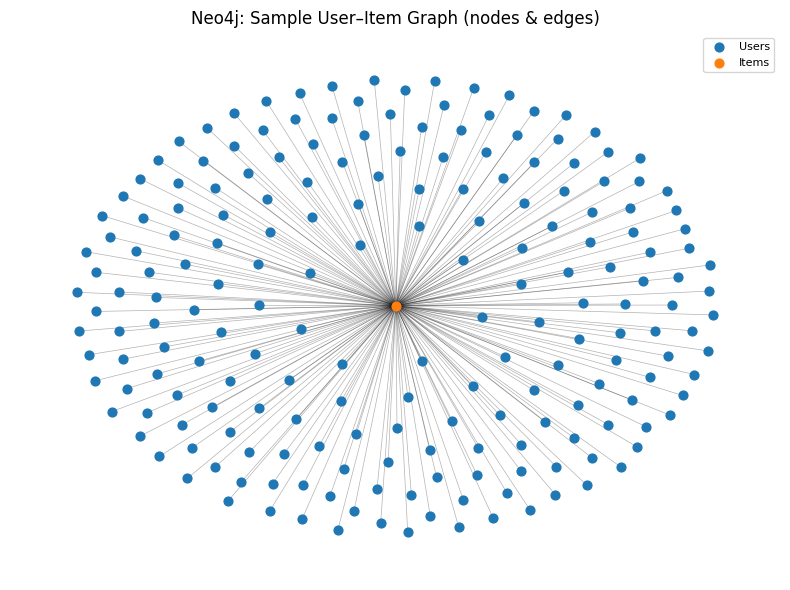

In [4]:
# === Robust Neo4j graph structure visualization (sample) ===
# This cell will:
# - Reuse an existing `driver` if it's still open
# - OR ask for URI/user/password and create a new driver
# - Then draw a small user–item graph

import matplotlib.pyplot as plt
import networkx as nx
import getpass

from neo4j import GraphDatabase
from neo4j.exceptions import DriverError

# 1) Ensure we have a working driver
need_new_driver = False

try:
    driver  # check if defined
    # try to open a session to see if it's still valid
    try:
        with driver.session() as _test_s:
            _test_s.run("RETURN 1 AS ok").single()
    except DriverError:
        need_new_driver = True
except NameError:
    driver = None
    need_new_driver = True

if need_new_driver or driver is None:
    print("🔌 Neo4j driver not available or closed. Please reconnect.")
    NEO4J_URI  = input("Neo4j URI (e.g., neo4j+s://<host>.databases.neo4j.io): ").strip()
    NEO4J_USER = input("Neo4j username [neo4j]: ").strip() or "neo4j"
    NEO4J_PASSWORD = getpass.getpass("Neo4j password: ")
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

print("\n=== Neo4j graph structure visualization (sample) ===")

# 2) Fetch a small edge sample from Neo4j
with driver.session() as session:
    sample_edges = session.run(
        """
        MATCH (u:User)-[:RATED]->(i:Item)
        RETURN u.userId AS userId, i.itemId AS itemId
        LIMIT 200
        """
    ).data()

if not sample_edges:
    print("⚠️ No edges returned from Neo4j, cannot draw graph.")
else:
    # 3) Build NetworkX graph
    G = nx.Graph()
    for row in sample_edges:
        u_node = f"u_{row['userId']}"
        i_node = f"i_{row['itemId']}"
        G.add_node(u_node, label="User")
        G.add_node(i_node, label="Item")
        G.add_edge(u_node, i_node)

    users = [n for n, d in G.nodes(data=True) if d.get("label") == "User"]
    items = [n for n, d in G.nodes(data=True) if d.get("label") == "Item"]

    # 4) Draw
    pos = nx.spring_layout(G, k=0.35, iterations=50, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, nodelist=users, node_color="tab:blue",
                           node_size=40, label="Users")
    nx.draw_networkx_nodes(G, pos, nodelist=items, node_color="tab:orange",
                           node_size=40, label="Items")
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
    plt.title("Neo4j: Sample User–Item Graph (nodes & edges)")
    plt.axis("off")
    plt.legend(scatterpoints=1, fontsize=8)
    plt.tight_layout()
    plt.show()


